In [1]:
import os
import sys
sys.path.append(r'C:\Study\SpeechAcquisitionModel')
print(os.getcwd())
import numpy as np
from scipy.spatial.distance import euclidean, minkowski
import scipy
import torch

import dtw
import dtwalign
from fastdtw import fastdtw

from sklearn.manifold import TSNE
import pandas as pd

from src.speech_classification.audio_processing import AudioPreprocessorMFCCDeltaDelta, SpeechCommandsDataCollector
from src.siamese_net_sound_similarity.slstm_train import SiameseSpeechCommandsDataCollector, StochasticSiameseLSTMNet
from src.siamese_net_sound_similarity.train_v2 import SiameseDeepLSTMNet
from src.siamese_net_sound_similarity.soft_dtw import SoftDTW



import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set()
sns.set(font_scale=1.4, rc={'text.usetex' : False})
sns.set_style("whitegrid")

%matplotlib inline

C:\Study\SpeechAcquisitionModel\src\dtw


In [2]:
DISTANCE='euclidean'
STEP_PATTERN = 'typeIc'
CLOSED_END_STEP_PATTERN = "typeIc"
# DISTANCE=lambda x, y : minkowski(x,y, 1)

## Load data

In [3]:
wanted_words = ['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left',
                'marvin',
                'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two',
                'up', 'wow', 'yes', 'zero']

wanted_words_combined = wanted_words

model_settings = {
    'dct_coefficient_count': 13,
    'label_count': len(wanted_words_combined) + 2,
    'hidden_reccurent_cells_count': 128,
    'winlen': 0.02,
    'winstep': 0.01
}
query_length = 100

In [4]:
preproc = AudioPreprocessorMFCCDeltaDelta(numcep=model_settings['dct_coefficient_count'], winlen=model_settings['winlen'],
                                     winstep=model_settings['winstep'])

data_iter = SiameseSpeechCommandsDataCollector(preproc,
                                        data_dir=r'C:\Study\Speech_command_classification\speech_dataset',
                                        wanted_words=wanted_words_combined,
                                        testing_percentage=10,
                                        validation_percentage=10
                                        )

index_to_word = {v:k for k,v in data_iter.word_to_index.items()}

In [5]:
n_mini_batch_size = 1
data = data_iter.get_data(n_mini_batch_size, 0, 'training')
labels = data['y']

duplicates = data_iter.get_duplicates(labels, 0, 'training')
assert np.any(labels == duplicates['y'])

non_duplicates = data_iter.get_nonduplicates(labels, 0, 'training')
assert np.any(labels != non_duplicates['y'])

Text(0.5,1,'negative DTW = 65.6422')

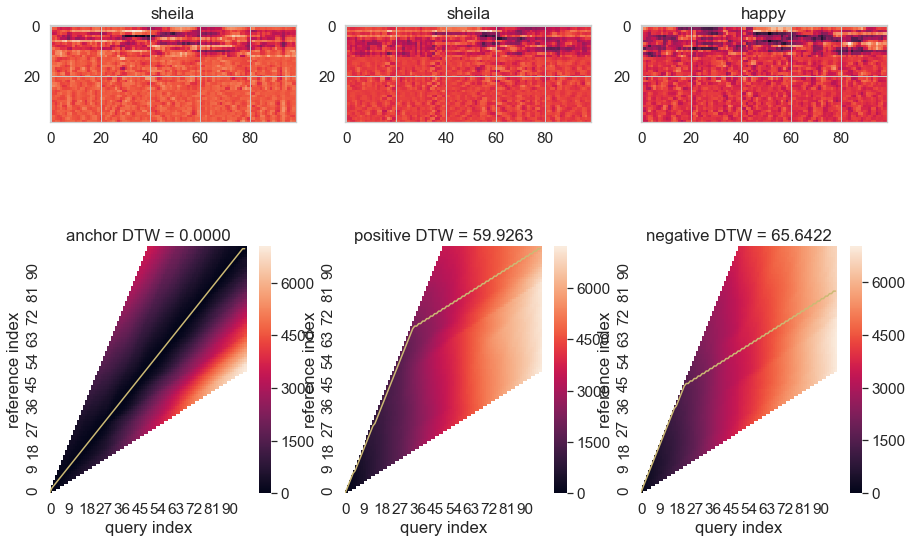

In [6]:

i = np.random.randint(data['y'].shape[0])
sample_idx = i

fig, axes = plt.subplots(2, 3, figsize=(15,10))

# plt.figure()
im = axes[0][0].imshow(data['x'][i].T)
# fig.colorbar(im)
label = index_to_word[data['y'][0]]
axes[0][0].title.set_text(f'{label}')

axes[0][1].imshow(duplicates['x'][i].T)
# plt.colorbar()
label = index_to_word[data['y'][0]]
axes[0][1].title.set_text(f'{label}')


axes[0][2].imshow(non_duplicates['x'][i].T)
# plt.colorbar()
label = index_to_word[non_duplicates['y'][0]]
axes[0][2].title.set_text(f'{label}')

######################################## DTW

x = data['x'][i]

# self dtw (extpected to be 0)

y = data['x'][i]
res = dtwalign.dtw(x, y, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=True)
res.plot_path(ax=axes[1][0])
axes[1][0].set_title(f"anchor DTW = {res.normalized_distance:.4f}")


# positive dtw

y = duplicates['x'][sample_idx]
res = dtwalign.dtw(x, y, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=True)
res.plot_path(ax=axes[1][1])
axes[1][1].set_title(f"positive DTW = {res.normalized_distance:.4f}")


# negative dtw

y = non_duplicates['x'][sample_idx]
res = dtwalign.dtw(x, y, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=True)
res.plot_path(ax=axes[1][2])
axes[1][2].set_title(f"negative DTW = {res.normalized_distance:.4f}")

# Gather Data for analysis

In [7]:
n_mini_batch_size = 2000

# # gather data
# data = data_iter.get_data(n_mini_batch_size, 0, 'validation')
# labels = data['y']

# data1 = data_iter.get_data(n_mini_batch_size, 0, 'validation')
# labels1 = data1['y']
# idx = np.random.randint(0, len(labels1), len(labels1))
# data1_x = data1['x'][idx]
# data1['x'] = data1_x
# labels1 =  np.array(data1['y'])[idx]
# data1['y'] = labels1




data = data_iter.get_data(n_mini_batch_size, 0, 'training')
labels = data['y']

duplicates = data_iter.get_duplicates(labels, 0, 'training')
assert np.any(labels == duplicates['y'])

non_duplicates = data_iter.get_nonduplicates(labels, 0, 'training')
assert np.any(labels != non_duplicates['y'])


## 1. DTW distribution on raw data

In [8]:

# initialize dist_lists

duplicates_dtw = []
non_duplicates_dtw = []

for i in range(n_mini_batch_size):
    print(i, end='\r')
    x = data['x'][i].squeeze()
    
    y_duplicate = duplicates['x'][i].squeeze()
    duplicates_dtw.append(dtwalign.dtw(x, y_duplicate, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=False, dist_only=True).normalized_distance)

    y_non_duplicate = non_duplicates['x'][i].squeeze()
    non_duplicates_dtw.append(dtwalign.dtw(x, y_non_duplicate, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=False, dist_only=True).normalized_distance)    

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


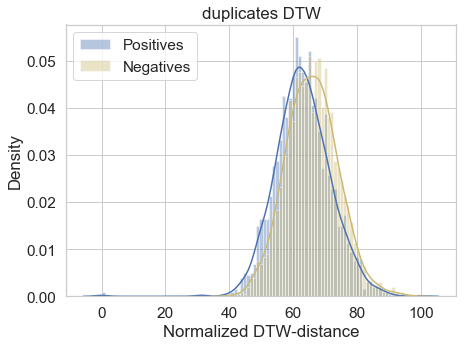

In [9]:
bins = np.linspace(0, min(max(np.max(duplicates_dtw), np.max(non_duplicates_dtw)), 150.), num=100)
fig, axes = plt.subplots(1, 1, figsize=(7,5))

duplicates_dtw_filtered = np.array(duplicates_dtw)[np.where(np.array(duplicates_dtw) < 150.)]
non_duplicates_dtw_filtered = np.array(non_duplicates_dtw)[np.where(np.array(non_duplicates_dtw) < 150.)]


sns.distplot(duplicates_dtw,  bins=bins, ax=axes, label="Positives")
axes.title.set_text('duplicates DTW')

sns.distplot(non_duplicates_dtw, bins=bins,  color='y', ax=axes, label="Negatives")
axes.legend()
plt.xlabel('Normalized DTW-distance')
plt.ylabel('Density')
plt.show()

### KL Divergence between two DTW distributions:

In [10]:
hist_dup, _ = np.histogram(duplicates_dtw)
hist_dup = hist_dup / np.sum(hist_dup)

hist_non_dup, _ = np.histogram(non_duplicates_dtw)
hist_non_dup = hist_non_dup / np.sum(hist_non_dup)

dkl = scipy.special.kl_div(hist_dup+1e-5, hist_non_dup+1e-5).sum()
print(f"DKL is: {dkl:.4f}")


DKL is: 0.9554


### As it can be seen, DTW calculated on MFCCs signals failed to capture different and similar samples showing no significant difference between duplicates and non-duplicates pairs. Kullback-Leibler divergence just proves this fact that P (distribution of distances between duplicate samples) and Q (non-duplicate ones) have no significant difference.

# 2. Improving DTW using AWEs

In [11]:
# load nn

nn_ce = r'C:\Study\SpeechAcquisitionModel\reports\seamise_net_10_27_2019_04_37_PM\net_0.5.net'
nn_ce_l2 = r'C:\Study\SpeechAcquisitionModel\reports\seamise_net_10_27_2019_02_19_PM\net_0.40625.net'
nn_ce_dtw = r'C:\Study\SpeechAcquisitionModel\reports\seamise_net_10_25_2019_01_55_PM\net_0.4609375.net'

nn_fnames = [nn_ce, nn_ce_l2, nn_ce_dtw]
nn_names = ['CE', 'CE+L2', 'CE+DTW']


## 2.1 - DTW

############################################################################
# MODEL : CE
############################################################################
############################################################################
# PREFIX LENGTH : 100
############################################################################


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


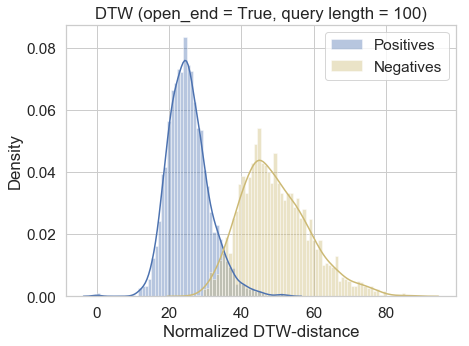

DKL is: 6.4542


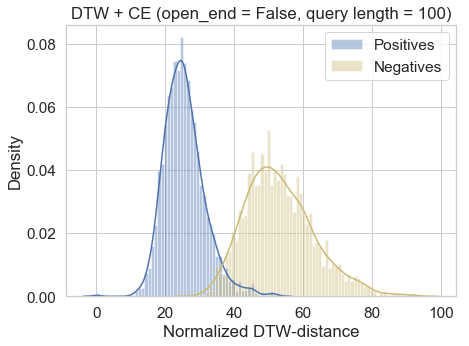

DKL is: 7.1795
############################################################################
# MODEL : CE+L2
############################################################################
############################################################################
# PREFIX LENGTH : 100
############################################################################


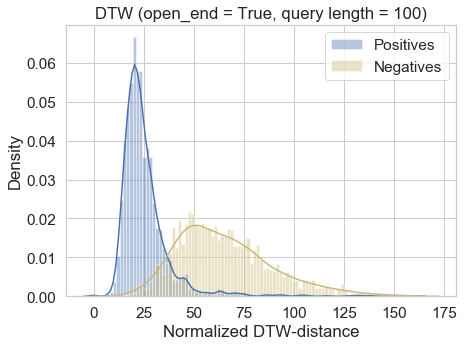

DKL is: 3.1096


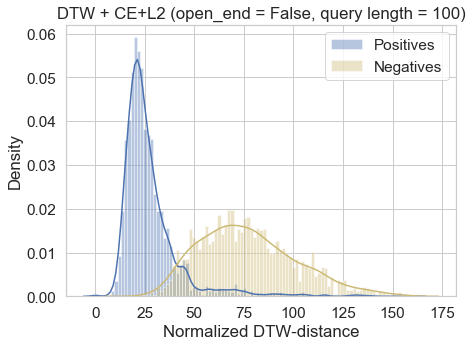

DKL is: 5.6634
############################################################################
# MODEL : CE+DTW
############################################################################
############################################################################
# PREFIX LENGTH : 100
############################################################################


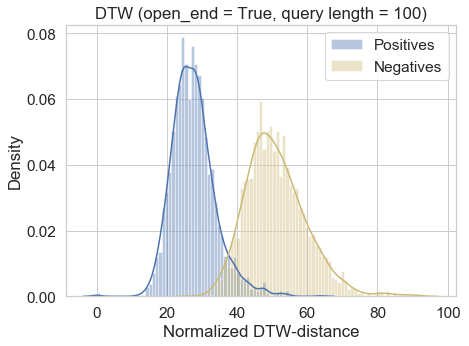

DKL is: 6.6830


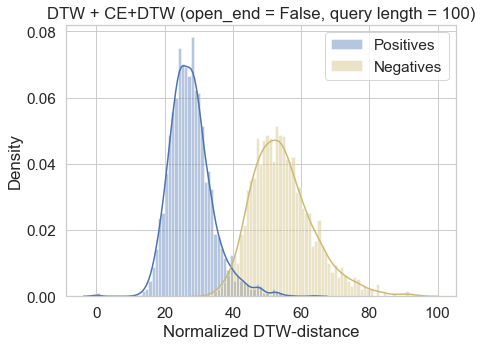

DKL is: 7.3939


In [12]:

for j in range(len(nn_fnames)):
    nn_fname = nn_fnames[j]
    nn = torch.load(nn_fname).cpu()
    nn.eval()

    print(f"############################################################################\n\
# MODEL : {nn_names[j]}\n\
############################################################################")
    
    PREFIX_LENS = [query_length]

    for PREFIX_LEN in PREFIX_LENS:
        print(f"############################################################################\n\
# PREFIX LENGTH : {PREFIX_LEN}\n\
############################################################################")
        nn_input = torch.from_numpy(data['x'][:, :PREFIX_LEN, :]).float()


        z, *_ = nn.single_forward(nn_input)
        z = z.cpu()
        z_detach = z.detach().cpu().numpy()

        duplicates_z, *_ = nn.single_forward(torch.from_numpy(duplicates['x']).float())
        duplicates_z = duplicates_z

        non_duplicates_z, *_ = nn.single_forward(torch.from_numpy(non_duplicates['x']).float())
        non_duplicates_z = non_duplicates_z.cpu()

        #########################################################################
        # Show example
        #########################################################################

    #     i = np.random.randint(data['y'].shape[0])
    #     sample_idx = i

    #     fig, axes = plt.subplots(1, 3, figsize=(15,10))

    #     # plt.figure()
    #     im = axes[0].imshow(z[i].T, vmin=-1, vmax=1)
    # #     axes[0][0].colorbar()
    #     label = index_to_word[data['y'][i]]
    #     axes[0].title.set_text(f'{label}')

    #     axes[1].imshow(duplicates_z[i].T, vmin=-1, vmax=1)
    #     # plt.colorbar()
    #     label = index_to_word[data['y'][i]]
    #     axes[1].title.set_text(f'{label}')


    #     axes[2].imshow(non_duplicates_z[i].T, vmin=-1, vmax=1)
    #     # plt.colorbar()
    #     label = index_to_word[non_duplicates['y'][i]]
    #     axes[2].title.set_text(f'{label}')

    #     # DTW

    #     x = z[sample_idx]

    #     # self dtw (extpected to be 0)

    #     y = z[sample_idx]
    #     res = dtwalign.dtw(x, y, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=True)
    #     res.plot_path(ax=axes[1][0])
    #     axes[1][0].set_title(f"anchor DTW = {res.normalized_distance:.4f}")


    #     # positive dtw

    #     y = duplicates_z[sample_idx]
    #     res = dtwalign.dtw(x, y, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=True)
    #     res.plot_path(ax=axes[1][1])
    #     axes[1][1].set_title(f"positive DTW = {res.normalized_distance:.4f}")


    #     # negative dtw

    #     y = non_duplicates_z[sample_idx]
    #     res = dtwalign.dtw(x, y, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=True)
    #     res.plot_path(ax=axes[1][2])
    #     axes[1][2].set_title(f"negative DTW = {res.normalized_distance:.4f}")

        plt.show()

        ###########################################################################
        # DTW
        ###########################################################################

        soft_dtw_loss_open_end = SoftDTW(open_end=True, dist='l1')
        soft_dtw_loss_close_end = SoftDTW(open_end=False, dist='l1')


        ##########################################################################
        #OPEN END = TRUE
        ##########################################################################

        # initialize dist_lists

        duplicates_dtw_z = []
        non_duplicates_dtw_z = []

        for i in range(n_mini_batch_size):
            print(i, end='\r')
            x = z[i].squeeze()

            y_duplicate = duplicates_z[i].squeeze()
            d = soft_dtw_loss_open_end(x, y_duplicate)
            duplicates_dtw_z.append(d.detach().cpu().numpy())

            y_non_duplicate = non_duplicates_z[i].squeeze()
            d = soft_dtw_loss_open_end(x, y_non_duplicate)
            non_duplicates_dtw_z.append(d.detach().cpu().numpy())

        # Show DTW

        bins = np.linspace(min(np.min(duplicates_dtw_z), np.min(non_duplicates_dtw_z)),
                           max(np.max(duplicates_dtw_z), np.max(non_duplicates_dtw_z)),
                           100)
        fig, axes = plt.subplots(1, 1, figsize=(7,5))

        sns.distplot(duplicates_dtw_z, bins=bins, ax=axes, label="Positives")
        axes.title.set_text(f'DTW (open_end = True, query length = {PREFIX_LEN})')
        plt.xlabel('Normalized DTW-distance')
        plt.ylabel('Density')


        sns.distplot(non_duplicates_dtw_z, bins=bins, color='y', ax=axes, label='Negatives')
        axes.legend()
        # axes[1].title.set_text('non-duplicates DTW')
        plt.show()

        hist_dup, _ = np.histogram(duplicates_dtw_z, bins=bins)
        hist_dup = hist_dup / np.sum(hist_dup)

        hist_non_dup, _ = np.histogram(non_duplicates_dtw_z, bins=bins)
        hist_non_dup = hist_non_dup / np.sum(hist_non_dup)

        dkl = scipy.special.kl_div(hist_dup+1e-5, hist_non_dup+1e-5).sum()
        print(f"DKL is: {dkl:.4f}")

    #     # plot matching segment length

    #     bins = np.linspace(0, 50., 50)
    #     fig, axes = plt.subplots(1, 1, figsize=(15,8))

    #     sns.distplot(duplicates_bmis, ax=axes,  label="Positives", kde=False, bins=bins)
    #     axes.title.set_text(f'Matching segment length (open_end = True, query length = {PREFIX_LEN})')

    #     sns.distplot(non_duplicates_bmis,   color='y', ax=axes, label='Negatives', kde=False, bins=bins)
    #     axes.legend()
    #     plt.xlabel('Best matching segment length (number of frames)')
    #     plt.ylabel('Density')
    #     plt.show()

        ##########################################################################
        # OPEN END = False
        ##########################################################################

        # initialize dist_lists

        duplicates_dtw_z = []
        non_duplicates_dtw_z = []

        duplicates_bmis = []
        non_duplicates_bmis = []

        for i in range(n_mini_batch_size):
            print(i, end='\r')
            x = z[i].squeeze()

            y_duplicate = duplicates_z[i].squeeze()
            d = soft_dtw_loss_close_end(x, y_duplicate)
            duplicates_dtw_z.append(d.detach().cpu().numpy())

            y_non_duplicate = non_duplicates_z[i].squeeze()
            d = soft_dtw_loss_close_end(x, y_non_duplicate)
            non_duplicates_dtw_z.append(d.detach().cpu().numpy())


        bins = np.linspace(min(np.min(duplicates_dtw_z), np.min(non_duplicates_dtw_z)),
                           max(np.max(duplicates_dtw_z), np.max(non_duplicates_dtw_z)),
                           100)
        fig, axes = plt.subplots(1, 1, figsize=(7,5))

        sns.distplot(duplicates_dtw_z, bins=bins, ax=axes, label="Positives")
        axes.title.set_text(f'DTW + {nn_names[j]} (open_end = False, query length = {PREFIX_LEN})')

        sns.distplot(non_duplicates_dtw_z, bins=bins, color='y', ax=axes, label='Negatives')
        axes.legend()
        plt.xlabel('Normalized DTW-distance')
        plt.ylabel('Density')
        # axes[1].title.set_text('non-duplicates DTW')
        plt.show()

        hist_dup, _ = np.histogram(duplicates_dtw_z, bins=bins)
        hist_dup = hist_dup / np.sum(hist_dup)

        hist_non_dup, _ = np.histogram(non_duplicates_dtw_z, bins=bins)
        hist_non_dup = hist_non_dup / np.sum(hist_non_dup)

        dkl = scipy.special.kl_div(hist_dup+1e-5, hist_non_dup+1e-5).sum()
        print(f"DKL is: {dkl:.4f}")
        
        del z, duplicates_z, non_duplicates_z




## Shane Settle Network

In [13]:
from src.siamese_net_sound_similarity.train_v3_adopted_from_settle import SiameseDeepLSTMNet
nn_settle = r'C:\Study\SpeechAcquisitionModel\reports\seamise_net_01_08_2020_04_28_PM\net_0.6484375.net'

nn_fnames = [nn_settle]
nn_names = ['Settle']

############################################################################
# MODEL : Settle
############################################################################
############################################################################
# PREFIX LENGTH : 100
############################################################################


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



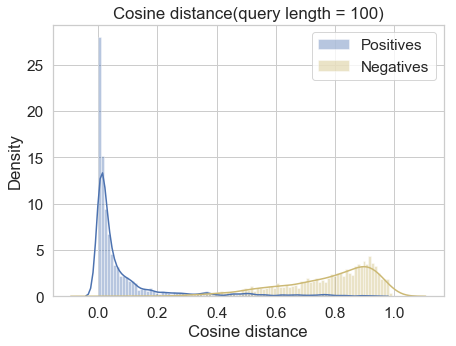

DKL is: 6.9603


In [14]:

for j in range(len(nn_fnames)):
    nn_fname = nn_fnames[j]
    nn = torch.load(nn_fname).cpu()
    nn.eval()

    print(f"############################################################################\n\
# MODEL : {nn_names[j]}\n\
############################################################################")
    
    PREFIX_LENS = [query_length]

    for PREFIX_LEN in PREFIX_LENS:
        print(f"############################################################################\n\
# PREFIX LENGTH : {PREFIX_LEN}\n\
############################################################################")
        nn_input = torch.from_numpy(data['x'][:, :PREFIX_LEN, :]).float()


        _, z = nn.single_forward(nn_input)
        z = z.cpu()
        
        _, duplicates_z = nn.single_forward(torch.from_numpy(duplicates['x']).float())
        duplicates_z = duplicates_z

        _, non_duplicates_z = nn.single_forward(torch.from_numpy(non_duplicates['x']).float())
        non_duplicates_z = non_duplicates_z.cpu()

        
        ###########################################################################
        # Cosine distance
        ###########################################################################

        # initialize dist_lists

        duplicates_cos_z = []
        non_duplicates_cos_z = []

        for i in range(n_mini_batch_size):
            print(i, end='\r')
            x = z[i].squeeze()

            y_duplicate = duplicates_z[i].squeeze()
            d = 1. - torch.nn.CosineSimilarity(dim=0)(x, y_duplicate)
            duplicates_cos_z.append(d.detach().cpu().numpy())

            y_non_duplicate = non_duplicates_z[i].squeeze()
            d = 1. - torch.nn.CosineSimilarity(dim=0)(x, y_non_duplicate)
            non_duplicates_cos_z.append(d.detach().cpu().numpy())

        # Show DTW
#         print(duplicates_cos_z.shape)
        bins = np.linspace(min(np.min(duplicates_cos_z), np.min(non_duplicates_cos_z)),
                           max(np.max(duplicates_cos_z), np.max(non_duplicates_cos_z)),
                           100)
#         print(bins)
        fig, axes = plt.subplots(1, 1, figsize=(7,5))

        sns.distplot(duplicates_cos_z, bins=bins, ax=axes, label="Positives")
        axes.title.set_text(f'Cosine distance(query length = {PREFIX_LEN})')
        plt.xlabel('Cosine distance')
        plt.ylabel('Density')


        sns.distplot(non_duplicates_cos_z, bins=bins, color='y', ax=axes, label='Negatives')
        axes.legend()
        # axes[1].title.set_text('non-duplicates DTW')
        plt.show()

        hist_dup, _ = np.histogram(duplicates_cos_z, bins=bins)
        hist_dup = hist_dup / np.sum(hist_dup)

        hist_non_dup, _ = np.histogram(non_duplicates_cos_z, bins=bins)
        hist_non_dup = hist_non_dup / np.sum(hist_non_dup)

        dkl = scipy.special.kl_div(hist_dup+1e-5, hist_non_dup+1e-5).sum()
        print(f"DKL is: {dkl:.4f}")

# 4. Improving DTW using AWEs with Shane Settle net

In [18]:
# load nn

from src.siamese_net_sound_similarity.train_v2_with_settle_structure import SiameseDeepLSTMNet

# nn_ce = r'C:\Study\SpeechAcquisitionModel\reports\seamise_net_01_09_2019_03_25_PM\net_0.5.net'
# nn_ce_l2 = r'C:\Study\SpeechAcquisitionModel\reports\seamise_net_10_27_2019_02_19_PM\net_0.40625.net'
nn_ce_dtw = r'C:\Study\SpeechAcquisitionModel\reports\seamise_net_01_09_2020_03_25_PM\net_0.5.net'

nn_fnames = [nn_ce_dtw]
nn_names = ['CE+DTW']

# nn_fnames = [nn_ce, nn_ce_l2, nn_ce_dtw]
# nn_names = ['CE', 'CE+L2', 'CE+DTW']


## 4.1 - DTW

In [19]:

for j in range(len(nn_fnames)):
    nn_fname = nn_fnames[j]
    nn = torch.load(nn_fname).cpu()
    nn.eval()

    print(f"############################################################################\n\
# MODEL : {nn_names[j]}\n\
############################################################################")
    
    PREFIX_LENS = [query_length]

    for PREFIX_LEN in PREFIX_LENS:
        print(f"############################################################################\n\
# PREFIX LENGTH : {PREFIX_LEN}\n\
############################################################################")
        nn_input = torch.from_numpy(data['x'][:, :PREFIX_LEN, :]).float()


        z, *_ = nn.single_forward(nn_input)
        z = z.cpu()
        z_detach = z.detach().cpu().numpy()

        duplicates_z, *_ = nn.single_forward(torch.from_numpy(duplicates['x']).float())
        duplicates_z = duplicates_z

        non_duplicates_z, *_ = nn.single_forward(torch.from_numpy(non_duplicates['x']).float())
        non_duplicates_z = non_duplicates_z.cpu()

        #########################################################################
        # Show example
        #########################################################################

    #     i = np.random.randint(data['y'].shape[0])
    #     sample_idx = i

    #     fig, axes = plt.subplots(1, 3, figsize=(15,10))

    #     # plt.figure()
    #     im = axes[0].imshow(z[i].T, vmin=-1, vmax=1)
    # #     axes[0][0].colorbar()
    #     label = index_to_word[data['y'][i]]
    #     axes[0].title.set_text(f'{label}')

    #     axes[1].imshow(duplicates_z[i].T, vmin=-1, vmax=1)
    #     # plt.colorbar()
    #     label = index_to_word[data['y'][i]]
    #     axes[1].title.set_text(f'{label}')


    #     axes[2].imshow(non_duplicates_z[i].T, vmin=-1, vmax=1)
    #     # plt.colorbar()
    #     label = index_to_word[non_duplicates['y'][i]]
    #     axes[2].title.set_text(f'{label}')

    #     # DTW

    #     x = z[sample_idx]

    #     # self dtw (extpected to be 0)

    #     y = z[sample_idx]
    #     res = dtwalign.dtw(x, y, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=True)
    #     res.plot_path(ax=axes[1][0])
    #     axes[1][0].set_title(f"anchor DTW = {res.normalized_distance:.4f}")


    #     # positive dtw

    #     y = duplicates_z[sample_idx]
    #     res = dtwalign.dtw(x, y, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=True)
    #     res.plot_path(ax=axes[1][1])
    #     axes[1][1].set_title(f"positive DTW = {res.normalized_distance:.4f}")


    #     # negative dtw

    #     y = non_duplicates_z[sample_idx]
    #     res = dtwalign.dtw(x, y, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=True)
    #     res.plot_path(ax=axes[1][2])
    #     axes[1][2].set_title(f"negative DTW = {res.normalized_distance:.4f}")

        plt.show()

        ###########################################################################
        # DTW
        ###########################################################################

        soft_dtw_loss_open_end = SoftDTW(open_end=True, dist='l1')
        soft_dtw_loss_close_end = SoftDTW(open_end=False, dist='l1')


        ##########################################################################
        #OPEN END = TRUE
        ##########################################################################

        # initialize dist_lists

        duplicates_dtw_z = []
        non_duplicates_dtw_z = []

        for i in range(n_mini_batch_size):
            print(i, end='\r')
            x = z[i].squeeze()

            y_duplicate = duplicates_z[i].squeeze()
            d = soft_dtw_loss_open_end(x, y_duplicate)
            duplicates_dtw_z.append(d.detach().cpu().numpy())

            y_non_duplicate = non_duplicates_z[i].squeeze()
            d = soft_dtw_loss_open_end(x, y_non_duplicate)
            non_duplicates_dtw_z.append(d.detach().cpu().numpy())

        # Show DTW

        bins = np.linspace(min(np.min(duplicates_dtw_z), np.min(non_duplicates_dtw_z)),
                           max(np.max(duplicates_dtw_z), np.max(non_duplicates_dtw_z)),
                           100)
        fig, axes = plt.subplots(1, 1, figsize=(7,5))

        sns.distplot(duplicates_dtw_z, bins=bins, ax=axes, label="Positives")
        axes.title.set_text(f'DTW (open_end = True, query length = {PREFIX_LEN})')
        plt.xlabel('Normalized DTW-distance')
        plt.ylabel('Density')


        sns.distplot(non_duplicates_dtw_z, bins=bins, color='y', ax=axes, label='Negatives')
        axes.legend()
        # axes[1].title.set_text('non-duplicates DTW')
        plt.show()

        hist_dup, _ = np.histogram(duplicates_dtw_z, bins=bins)
        hist_dup = hist_dup / np.sum(hist_dup)

        hist_non_dup, _ = np.histogram(non_duplicates_dtw_z, bins=bins)
        hist_non_dup = hist_non_dup / np.sum(hist_non_dup)

        dkl = scipy.special.kl_div(hist_dup+1e-5, hist_non_dup+1e-5).sum()
        print(f"DKL is: {dkl:.4f}")

    #     # plot matching segment length

    #     bins = np.linspace(0, 50., 50)
    #     fig, axes = plt.subplots(1, 1, figsize=(15,8))

    #     sns.distplot(duplicates_bmis, ax=axes,  label="Positives", kde=False, bins=bins)
    #     axes.title.set_text(f'Matching segment length (open_end = True, query length = {PREFIX_LEN})')

    #     sns.distplot(non_duplicates_bmis,   color='y', ax=axes, label='Negatives', kde=False, bins=bins)
    #     axes.legend()
    #     plt.xlabel('Best matching segment length (number of frames)')
    #     plt.ylabel('Density')
    #     plt.show()

        ##########################################################################
        # OPEN END = False
        ##########################################################################

        # initialize dist_lists

        duplicates_dtw_z = []
        non_duplicates_dtw_z = []

        duplicates_bmis = []
        non_duplicates_bmis = []

        for i in range(n_mini_batch_size):
            print(i, end='\r')
            x = z[i].squeeze()

            y_duplicate = duplicates_z[i].squeeze()
            d = soft_dtw_loss_close_end(x, y_duplicate)
            duplicates_dtw_z.append(d.detach().cpu().numpy())

            y_non_duplicate = non_duplicates_z[i].squeeze()
            d = soft_dtw_loss_close_end(x, y_non_duplicate)
            non_duplicates_dtw_z.append(d.detach().cpu().numpy())


        bins = np.linspace(min(np.min(duplicates_dtw_z), np.min(non_duplicates_dtw_z)),
                           max(np.max(duplicates_dtw_z), np.max(non_duplicates_dtw_z)),
                           100)
        fig, axes = plt.subplots(1, 1, figsize=(7,5))

        sns.distplot(duplicates_dtw_z, bins=bins, ax=axes, label="Positives")
        axes.title.set_text(f'DTW + {nn_names[j]} (open_end = False, query length = {PREFIX_LEN})')

        sns.distplot(non_duplicates_dtw_z, bins=bins, color='y', ax=axes, label='Negatives')
        axes.legend()
        plt.xlabel('Normalized DTW-distance')
        plt.ylabel('Density')
        # axes[1].title.set_text('non-duplicates DTW')
        plt.show()

        hist_dup, _ = np.histogram(duplicates_dtw_z, bins=bins)
        hist_dup = hist_dup / np.sum(hist_dup)

        hist_non_dup, _ = np.histogram(non_duplicates_dtw_z, bins=bins)
        hist_non_dup = hist_non_dup / np.sum(hist_non_dup)

        dkl = scipy.special.kl_div(hist_dup+1e-5, hist_non_dup+1e-5).sum()
        print(f"DKL is: {dkl:.4f}")




C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:453: SourceChangeWarning: source code of class 'src.siamese_net_sound_similarity.train_v2_with_settle_structure.SiameseDeepLSTMNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


############################################################################
# MODEL : CE+DTW
############################################################################
############################################################################
# PREFIX LENGTH : 100
############################################################################


AttributeError: 'SiameseDeepLSTMNet' object has no attribute '_SiameseDeepLSTMNet__lstm_2'